In [22]:
import os
import shutil
import pandas as pd
from multiprocessing import Pool
import tqdm
import numpy as np
import glob as glob
from skimage.io import imread, imsave
import osmnx as ox
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
from osgeo import gdal, ogr, osr
import cv2
import subprocess
import shapely
from shapely.geometry import MultiLineString
from matplotlib.patches import PathPatch
import matplotlib.path

%matplotib inline
%pylab inline

UsageError: Line magic function `%matplotib` not found.


Constants

In [2]:
imgs = []
buffer_meters = 2
burnValue = 150

Create a buffer around the lines of the geojson. Return a geodataframe.

In [3]:
def create_buffer_geopandas(geoJsonFileName,
                            bufferDistanceMeters=2, 
                            bufferRoundness=1,
                            projectToUTM=True):
    
    inGDF = gpd.read_file(geoJsonFileName)

    inGDF['type'] = inGDF['road_type'].values            
    inGDF['class'] = 'highway'  
    inGDF['highway'] = 'highway'  
    
    if len(inGDF) == 0:
        return [], []

    if projectToUTM:
        tmpGDF = ox.project_gdf(inGDF)
    else:
        tmpGDF = inGDF

    gdf_utm_buffer = tmpGDF

    gdf_utm_buffer['geometry'] = tmpGDF.buffer(bufferDistanceMeters,
                                                bufferRoundness)

    gdf_utm_dissolve = gdf_utm_buffer.dissolve(by='class')
    gdf_utm_dissolve.crs = gdf_utm_buffer.crs

    if projectToUTM:
        gdf_buffer = gdf_utm_dissolve.to_crs(inGDF.crs)
    else:
        gdf_buffer = gdf_utm_dissolve

    return gdf_buffer

In [4]:
def gdf_to_array(gdf, im_file, output_raster, burnValue=150):
    
    NoData_value = 0      # -9999

    gdata = gdal.Open(im_file)
    
    target_ds = gdal.GetDriverByName('GTiff').Create(output_raster, 
                                                     gdata.RasterXSize, 
                                                     gdata.RasterYSize, 1, gdal.GDT_Byte)
    target_ds.SetGeoTransform(gdata.GetGeoTransform())
    
    raster_srs = osr.SpatialReference()
    raster_srs.ImportFromWkt(gdata.GetProjectionRef())
    target_ds.SetProjection(raster_srs.ExportToWkt())
    
    band = target_ds.GetRasterBand(1)
    band.SetNoDataValue(NoData_value)
    
    outdriver=ogr.GetDriverByName('MEMORY')
    outDataSource=outdriver.CreateDataSource('memData')
    tmp=outdriver.Open('memData',1)
    outLayer = outDataSource.CreateLayer("states_extent", raster_srs, 
                                         geom_type=ogr.wkbMultiPolygon)
    burnField = "burn"
    idField = ogr.FieldDefn(burnField, ogr.OFTInteger)
    outLayer.CreateField(idField)
    featureDefn = outLayer.GetLayerDefn()
    for geomShape in gdf['geometry'].values:
        
        outFeature = ogr.Feature(featureDefn)
        outFeature.SetGeometry(ogr.CreateGeometryFromWkt(geomShape.wkt))
        outFeature.SetField(burnField, burnValue)
        outLayer.CreateFeature(outFeature)
        outFeature = 0
    
    gdal.RasterizeLayer(target_ds, [1], outLayer, burn_values=[burnValue])
    outLayer = 0
    outDatSource = 0
    tmp = 0   
    return 

In [5]:
def convert_to_8Bit(inputRaster, outputRaster,
                           outputPixType='Byte',
                           outputFormat='GTiff',
                           rescale_type='rescale',
                           percentiles=[2, 98]):

    srcRaster = gdal.Open(inputRaster)
    cmd = ['gdal_translate', '-ot', outputPixType, '-of', 
           outputFormat]
    
    for bandId in range(srcRaster.RasterCount):
        bandId = bandId+1
        band = srcRaster.GetRasterBand(bandId)
        if rescale_type == 'rescale':
            bmin = band.GetMinimum()        
            bmax = band.GetMaximum()
            if bmin is None or bmax is None:
                (bmin, bmax) = band.ComputeRasterMinMax(1)
            band_arr_tmp = band.ReadAsArray()
            bmin = np.percentile(band_arr_tmp.flatten(), 
                                 percentiles[0])
            bmax= np.percentile(band_arr_tmp.flatten(), 
                                percentiles[1])

        else:
            bmin, bmax = 0, 65535

        cmd.append('-scale_{}'.format(bandId))
        cmd.append('{}'.format(bmin))
        cmd.append('{}'.format(bmax))
        cmd.append('{}'.format(0))
        cmd.append('{}'.format(255))

    cmd.append(inputRaster)
    cmd.append(outputRaster)
    # print("Conversin command:", cmd)
    subprocess.call(cmd)
    return

Get buffer around roads defined by geojson and image files. Calls create_buffer_geopandas() and gdf_to_array().
Assumes in_vis_file is an 8-bit RGB file. Returns geodataframe and ouptut mask.

In [6]:
def get_road_buffer(geoJson, im_vis_file, output_raster, 
                              buffer_meters=2, burnValue=1, 
                              bufferRoundness=6, 
                              plot_file='', figsize=(6,6), fontsize=6,
                              dpi=800, show_plot=False, 
                              verbose=False):    

    gdf_buffer = create_buffer_geopandas(geoJson,
                                         bufferDistanceMeters=buffer_meters,
                                         bufferRoundness=bufferRoundness, 
                                         projectToUTM=True)    

    
    # create label image
    if len(gdf_buffer) == 0:
        mask_gray = np.zeros(cv2.imread(im_vis_file,0).shape)
        cv2.imwrite(output_raster, mask_gray)        
    else:
        gdf_to_array(gdf_buffer, im_vis_file, output_raster, 
                                          burnValue=burnValue)
    
    mask_gray = cv2.imread(output_raster, 0)
    if plot_file:
        if (figsize[0] != figsize[1]):
            fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=figsize)#(13,4))
        else:
            fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2, figsize=figsize)

        try:
            gdfRoadLines = gpd.read_file(geoJson)
            gdfRoadLines.plot(ax=ax0, marker='o', color='red')
        except:
            ax0.imshow(mask_gray)
        ax0.axis('off')
        ax0.set_aspect('equal')
        ax0.set_title('Roads from GeoJson', fontsize=fontsize)
                
        im_vis = cv2.imread(im_vis_file, 1)
        img_mpl = cv2.cvtColor(im_vis, cv2.COLOR_BGR2RGB)
        ax1.imshow(img_mpl)
        ax1.axis('off')
        ax1.set_title('8-bit RGB Image', fontsize=fontsize)
        
        ax2.imshow(mask_gray)
        ax2.axis('off')
        ax2.set_title('Roads Mask (' + str(np.round(buffer_meters)) \
                                   + ' meter buffer)', fontsize=fontsize)
     

        ax3.imshow(img_mpl)    
        z = mask_gray.astype(float)
        z[z==0] = np.nan
        palette = plt.cm.gray
        palette.set_over('lime', 0.9)
        ax3.imshow(z, cmap=palette, alpha=0.66, 
                norm=matplotlib.colors.Normalize(vmin=0.5, vmax=0.9, clip=False))
        ax3.set_title('8-bit RGB Image + Buffered Roads', fontsize=fontsize) 
        ax3.axis('off')
        
        #plt.axes().set_aspect('equal', 'datalim')

        plt.tight_layout()
        plt.savefig(plot_file, dpi=dpi)
        if not show_plot:
            plt.close()    
    return mask_gray, gdf_buffer

In [7]:
def create_binary_mask(filename, input_data):
    base_path = os.getcwd()
    img_path = os.path.join(base_path,input_data[0],filename)
    bit8_path = os.path.join(base_path,input_data[1],filename)
    label_file = os.path.join(base_path,input_data[2],filename[:-4]+'_label.geojson')
    mask_path = os.path.join(base_path,input_data[3],filename[:-3]+'png')
    #plot_file = os.path.join(base_path,)
    convert_to_8Bit(img_path, 
                    bit8_path,
                    outputPixType='Byte',
                    outputFormat='GTiff',
                    rescale_type='rescale',
                    percentiles=[2,98])

    # create masks
    # note that though the output raster file has .png extension
    # in reality I delete this file and save only jpg version later
    # create paths for masks and 8bit images
    
    mask, gdf_buffer = get_road_buffer(geoJson = label_file,
                                        im_vis_file = bit8_path, 
                                        output_raster = mask_path, 
                                        buffer_meters= buffer_meters, 
                                        burnValue= burnValue, 
                                        bufferRoundness=6, 
                                        plot_file='', # this indicates that no visualization plot is required 
                                        figsize= (6,6),
                                        fontsize=8,
                                        dpi=200,
                                        show_plot=False, 
                                        verbose=False)

    # read the png file, save it as jpeg and 
    mask_m = imread(mask_path)
    imsave(fname=mask_path[:-3]+'jpg',arr = mask_m)
    mask_max = np.max(mask_m) 
    del mask_m
    # remove the png file, but keep the 8-bit mask
    os.remove(mask_path)  
    return mask_max

Datasets paths

In [17]:
path_data = [r'sn3_AOI_2_Vegas\new_dataset', r'sn3_AOI_2_Vegas\bit8_dataset',
              r'sn3_AOI_2_Vegas\new_labels',r'sn3_AOI_2_Vegas\bit8_masks',
              r'sn3_AOI_2_Vegas','Vegas']

In [26]:
path_data = [r'sn3_AOI_4_Shanghai\new_dataset', r'sn3_AOI_4_Shanghai\bit8_dataset',
              r'sn3_AOI_4_Shanghai\new_labels',r'sn3_AOI_4_Shanghai\bit8_masks',
              r'sn3_AOI_4_Shanghai','Shanghai']

In [18]:
path_data = [r'sn3_AOI_5_Khartoum\new_dataset', r'sn3_AOI_5_Khartoum\bit8_dataset',
              r'sn3_AOI_5_Khartoum\new_labels',r'sn3_AOI_5_Khartoum\bit8_masks',
              r'sn3_AOI_5_Khartoum','Khartoum']

In [8]:
path_data = [r'sn3_AOI_3_Paris\new_dataset', r'sn3_AOI_3_Paris\bit8_dataset',
              r'sn3_AOI_3_Paris\new_labels',r'sn3_AOI_3_Paris\bit8_masks',
              r'sn3_AOI_3_Paris','Paris']

Creating folders

In [9]:
base_path = os.getcwd()
if not os.path.exists(os.path.join(base_path,path_data[0])):
        os.mkdir(os.path.join(base_path,path_data[0]))
if not os.path.exists(os.path.join(base_path,path_data[1])):
    os.mkdir(os.path.join(base_path,path_data[1]))
if not os.path.exists(os.path.join(base_path,path_data[2])):
        os.mkdir(os.path.join(base_path,path_data[2]))
if not os.path.exists(os.path.join(base_path,path_data[3])):
    os.mkdir(os.path.join(base_path,path_data[3]))

Moving only neccessary files

In [ ]:
'''set_path = os.path.join(base_path,path_data[4])
newset_path = os.path.join(base_path,path_data[0])
input_data = []
for filename in os.listdir(set_path):
    if filename.startswith('sn3') and not filename.endswith("-labels"):
        image = os.path.join(set_path,filename,'labels.geojson')
        shutil.copyfile(image, os.path.join(newset_path, f'{path_data[5]}_{i}_label.geojson'))
        
    elif filename.startswith('sn3'):
        image = os.path.join(set_path,filename,'PS-RGB.tif')
        shutil.move(image, os.path.join(newset_path, f'{path_data[5]}_{i}.tif'))'''

In [10]:
set_path = os.path.join(base_path,path_data[4])
img_path = os.path.join(base_path,path_data[0])
json_path = os.path.join(base_path,path_data[2])
i = 0
j = 0
for filename in os.listdir(set_path):
    if filename.endswith("-labels"):
        image = os.path.join(set_path,filename,'labels.geojson')
        shutil.copyfile(image, os.path.join(json_path, f'{path_data[5]}_{i}_label.geojson'))
        i+=1
    elif filename.startswith('sn3'):
        image = os.path.join(set_path,filename,'PS-RGB.tif')
        shutil.copyfile(image, os.path.join(img_path, f'{path_data[5]}_{i}.tif'))
        j+=1

Creating images and masks

In [11]:
set_path = os.path.join(base_path,path_data[0])
input_data = [item for item in os.listdir(set_path)]

In [ ]:
mask_data = list(map(lambda filename: create_binary_mask(filename, path_data), input_data))

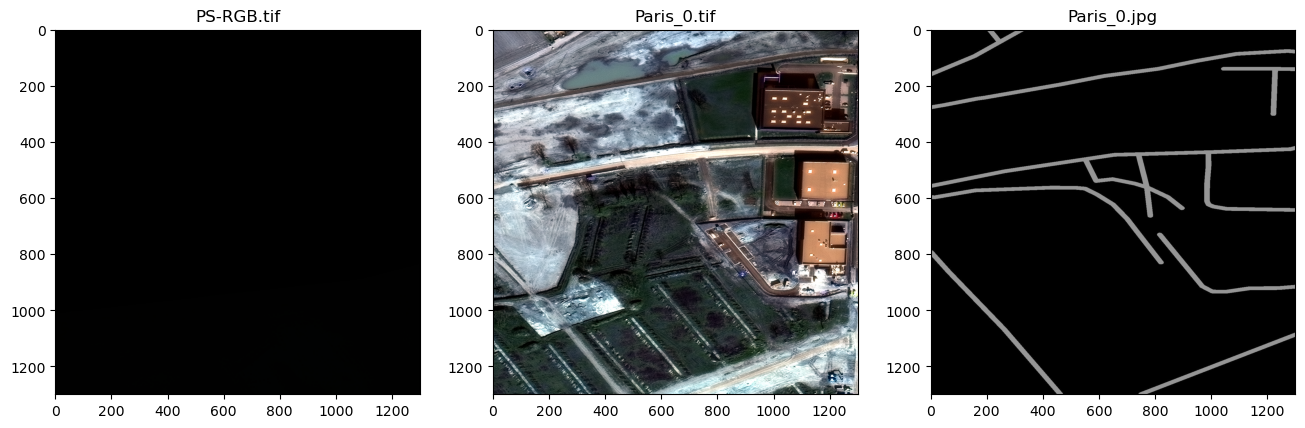

In [38]:
a = cv2.imread(r'.\roads_processing\sn3_AOI_3_Paris\sn3_SN3_roads_train_AOI_3_Paris_PS-RGB_img6\PS-RGB.tif')

b = cv2.imread(r'.\roads_processing\sn3_AOI_3_Paris\bit8_dataset\Paris_0.tif')
c = cv2.imread(r'.\roads_processing\sn3_AOI_3_Paris\bit8_masks\Paris_0.jpg')

plt.figure(figsize = (16, 12))
plt.subplot(1, 3, 1)
plt.title('PS-RGB.tif')
plt.imshow(a)

plt.subplot(1, 3, 2)
plt.title('Paris_0.tif')
plt.imshow(b)

plt.subplot(1,3,3)
plt.title('Paris_0.jpg')
plt.imshow(c)
plt.show()